<a href="https://colab.research.google.com/github/educanto/keras_fashion_mnist/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports and functions**

In [1]:
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import math

In [33]:
def plot_top_losses(loss_values, x_test, y_test, pred, k=9, figsize=(10,10)):
    top_k = loss_values.argsort()[-k:][::-1]
    print('top losses indexes: ', top_k)
    cols = math.ceil(math.sqrt(k))
    rows = math.ceil(k/cols)
    fig,axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle('Prediction/Actual/Loss/Prediction_Probability', weight='bold', size=14).set_position([.5, 1.05])
    i=0
    for index in top_k:
        image = x_test[index]
        actual = y_test[index]
        loss_value = loss_values[index]
        predicted = np.argmax(pred[index])
        prob = pred[index][predicted]
        title = f'{labels[predicted]}/{labels[actual]}/{loss_value:.2f}/{prob:.2f}'
        ax = axes.flat[i]
        i+=1
        image = np.squeeze(image)
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
    fig.tight_layout() 

# **Loading dataset**

In [8]:
dataset = keras.datasets.fashion_mnist
((x_train, y_train), (x_test, y_test)) = dataset.load_data()

labels = {0:'Camiseta', 1:'Calça', 2:'Pullover',3:'Vestido', 4:'Casaco', 5:'Sandália', 6:'Camisa', 7:'Tênis', 8:'Bolsa', 9:'Bota'}

# **Checking dataset**

In [9]:
print(x_train.shape)
print(x_test.shape)

print(y_train.min())
print(y_train.max())

(60000, 28, 28)
(10000, 28, 28)
0
9


# **Showing some data**

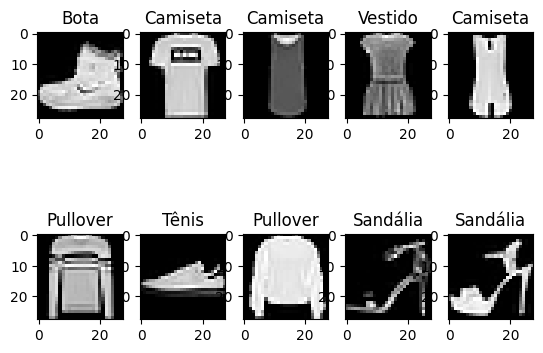

In [10]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(labels[y_train[i]])

# **Normalizing and reshaping images**

In [11]:
# reshape dataset to have a single channel
x_train_res = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test_res = x_test.reshape((x_test.shape[0], 28, 28, 1))

x_train_norm = x_train/float(255)
x_test_norm = x_test/float(255)

# **Create and compile model**

In [23]:
model = keras.Sequential([ 
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(10, activation='softmax')
])

#keras.io/api/optimizers/adam/
optimizer = keras.optimizers.AdamW(learning_rate=1e-04)

#keras.io/api/callbacks/
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=2),
             keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5',
                                            monitor='val_loss',
                                            save_best_only=True)]

model.compile(optimizer=optimizer, 
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model.summary()
model.get_config()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 5408)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               1384704   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                2570      
                                                      

{'name': 'sequential_6',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 28, 28, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv2d_6_input'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_6',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 28, 28, 1),
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_6',
    'trainable': True,

# **Train model**

In [24]:
historical = model.fit(x_train_norm, y_train, 
                       batch_size=64, 
                       epochs=15, 
                       validation_split=0.2,
                       callbacks=callbacks)

Epoch 1/15
750/750 [==============================] - 4s 4ms/step - loss: 0.6464 - accuracy: 0.7896 - val_loss: 0.4297 - val_accuracy: 0.8508
Epoch 2/15
750/750 [==============================] - 4s 5ms/step - loss: 0.4067 - accuracy: 0.8585 - val_loss: 0.3786 - val_accuracy: 0.8679
Epoch 3/15
750/750 [==============================] - 3s 4ms/step - loss: 0.3603 - accuracy: 0.8748 - val_loss: 0.3453 - val_accuracy: 0.8783
Epoch 4/15
750/750 [==============================] - 3s 4ms/step - loss: 0.3317 - accuracy: 0.8849 - val_loss: 0.3277 - val_accuracy: 0.8848
Epoch 5/15
750/750 [==============================] - 3s 4ms/step - loss: 0.3113 - accuracy: 0.8903 - val_loss: 0.3279 - val_accuracy: 0.8826
Epoch 6/15
750/750 [==============================] - 3s 4ms/step - loss: 0.2945 - accuracy: 0.8960 - val_loss: 0.3018 - val_accuracy: 0.8930
Epoch 7/15
750/750 [==============================] - 3s 4ms/step - loss: 0.2811 - accuracy: 0.9004 - val_loss: 0.2892 - val_accuracy: 0.8959
Epoch 

# **Results**

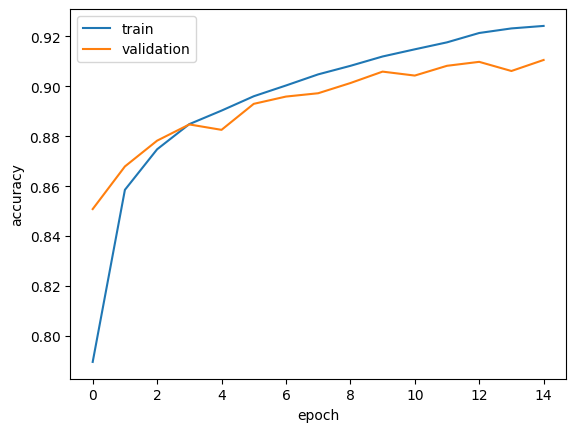

In [25]:
plt.plot(historical.history['accuracy'])
plt.plot(historical.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])


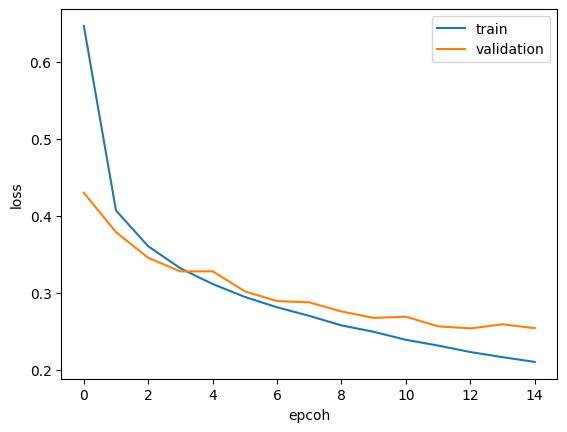

In [26]:
plt.plot(historical.history['loss'])
plt.plot(historical.history['val_loss'])
plt.xlabel('epcoh')
plt.ylabel('loss')
plt.legend(['train', 'validation'])

# **Save model**

In [27]:
model.save('model.h5')

# **Load model**

In [36]:
loaded_model = keras.models.load_model('model.h5')

# **Testing loaded model**

In [29]:
test_pred = model.predict(x_test_norm)
print('test result:', np.argmax(test_pred[1]))
print('test image number:', y_test[1])

tests_saved_model = loaded_model.predict(x_test_norm)
print('test result saved model:', np.argmax(tests_saved_model[1]))
print('test image number:', y_test[1])

313/313 [==============================] - 1s 2ms/step
test result: 2
test image number: 2
313/313 [==============================] - 1s 2ms/step
test result saved model: 2
test image number: 2


# **Evaluating the model**

In [30]:
test_loss, acc_test = model.evaluate(x_test_norm, y_test)
print('test loss:', test_loss)
print('test accuracy:', acc_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2697 - accuracy: 0.9017
test loss: 0.26966163516044617
test accuracy: 0.9017000198364258


# **Plotting top losses**

In [31]:
loss = keras.losses.SparseCategoricalCrossentropy(reduction=keras.losses.Reduction.NONE)
loss_values = loss(y_test,test_pred).numpy()
print(loss_values)

[7.4455433e-02 7.0963945e-04 8.5830325e-06 ... 4.5614950e-03 2.1002471e-04
 2.6477760e-01]


top losses indexes:  [  23 5512 1980  979 8914 5006 2817  787 9017   68 5052 4251 1300 3531
  732 1878]


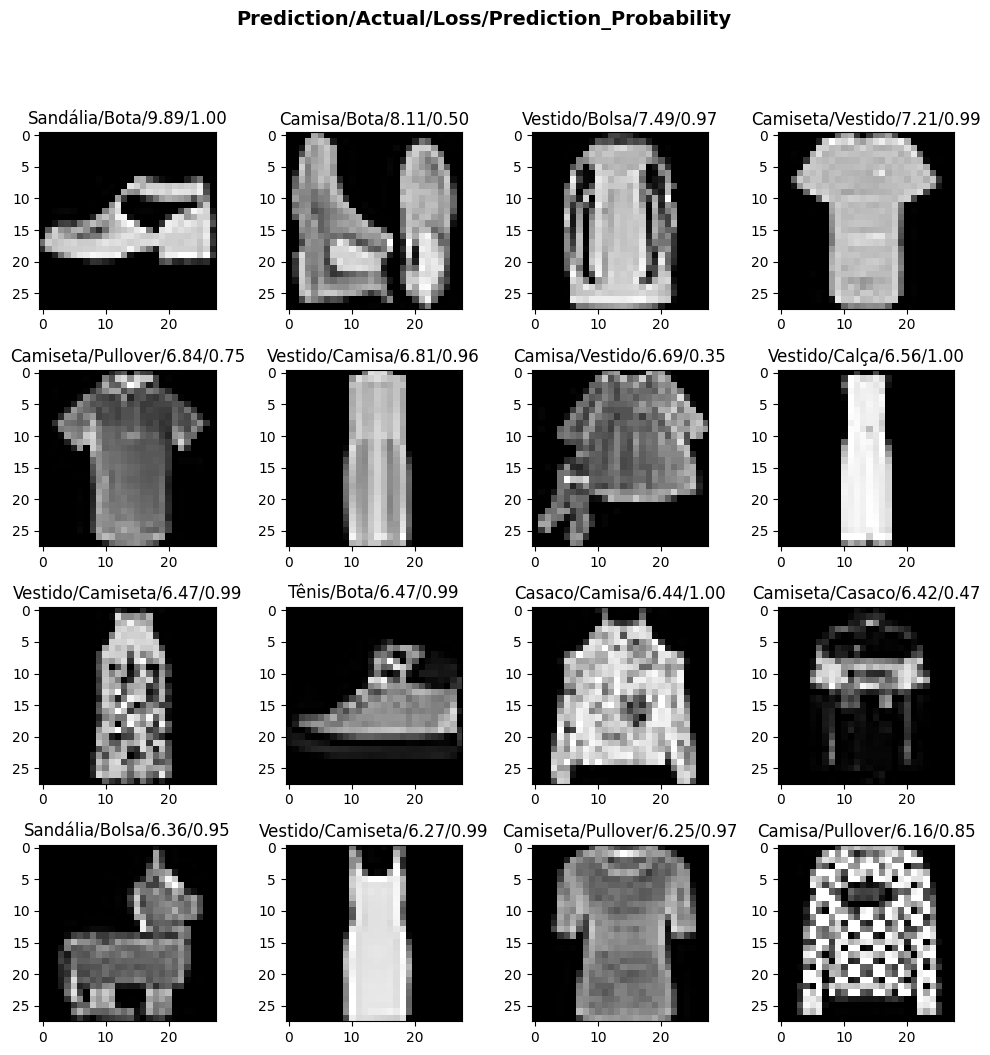

In [34]:
plot_top_losses(loss_values, x_test, y_test, test_pred, k=16)